# Increasing Nodes Results

These results plot our simulation metrics against increasing system sizes. 

In [1]:
%load_ext memory_profiler
%matplotlib inline

import os
import sys 
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import graph_tool.all as gt
import matplotlib.pyplot as plt

from operator import itemgetter
from itertools import groupby, chain
from collections import defaultdict, Counter

# Modify the Notebook path
sys.path.append(os.path.join(os.getcwd(), ".."))

from cloudscope.colors import ColorMap
from cloudscope.results import Results
from cloudscope.results.graph import extract_graph
from cloudscope.results.analysis import create_per_replica_dataframe as create_replica_dataframe
from cloudscope.results.analysis import create_per_experiment_dataframe as create_dataframe

In [9]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('Set1')

In [3]:
# Specify a path to a results file 
# If None, will attempt to look one up
FIXTURES = os.path.join("..", "fixtures", "results")
FIGURES  = os.path.join("..", "fixtures", "figures", "scaling-systems")
RESULTS  = os.path.join(FIXTURES, "scaling-systems.json")

def get_results_data(path=RESULTS):
    with open(path, 'r') as f:
        for line in f:
            yield Results.load(line)

In [4]:
%%memit 
df = create_dataframe(get_results_data())

peak memory: 4525.05 MiB, increment: 4397.36 MiB


In [5]:
# Uncomment below if you need to see the columns
# print("\n".join(df.columns))

# Add the ename to identify the experiment
df['ename'] = df['users'].apply(str) + " " + df['type'] + " nodes"
df['type']  = df['type'].apply(lambda s: s.title())

In [6]:
df

,T parameter model,anti-entropy delay (ms),committed writes,completed reads,completed writes,conflict probability,dropped messages,dropped writes,eid,"election timeout (ms, ms)",...,simulation time (secs),stale reads,standard deviation of latency (ms),tick metric (T),type,users,visibility,visible writes,writes,ename
0,bailis,600,25009.0,34495,25070,0.0,0,127.0,e00,"[10000, 20000]",...,42.966358,6804,56,10000,Raft,25,601680,25009,25197,25 raft nodes
1,bailis,600,4971.0,6843,5007,0.0,0,13.0,e01,"[10000, 20000]",...,5.203961,242,56,10000,Raft,5,20028,4971,5020,5 raft nodes
2,bailis,2500,0.0,6897,5020,0.0,0,0.0,e02,"[150, 300]",...,160.447981,228,56,10000,Eventual,5,16145,3017,5020,5 eventual nodes
3,bailis,600,49878.0,68701,49945,0.0,0,519.0,e03,"[10000, 20000]",...,144.145749,23562,56,10000,Raft,50,2447305,49878,50464,50 raft nodes
4,bailis,600,75098.0,103646,75212,0.0,0,397.0,e04,"[10000, 20000]",...,330.571439,48383,56,10000,Raft,75,5565688,75098,75609,75 raft nodes
5,bailis,600,99441.0,137254,99581,0.0,0,1206.0,e05,"[10000, 20000]",...,649.041390,77240,56,10000,Raft,100,9858519,99441,100787,100 raft nodes
6,bailis,2500,0.0,34731,25197,0.0,0,0.0,e06,"[150, 300]",...,1107.648522,7591,56,10000,Eventual,25,385735,5857,25197,25 eventual nodes
7,bailis,2500,0.0,69419,50464,0.0,0,0.0,e07,"[150, 300]",...,3814.667379,26507,56,10000,Eventual,50,1419539,6515,50464,50 eventual nodes
8,bailis,2500,0.0,104177,75609,0.0,0,0.0,e08,"[150, 300]",...,7611.057827,53889,56,10000,Eventual,75,2904279,5749,75609,75 eventual nodes
9,bailis,2500,0.0,139032,100787,0.0,0,0.0,e09,"[150, 300]",...,17864.935510,85514,56,10000,Eventual,100,4716825,4822,100787,100 eventual nodes


peak memory: 222.09 MiB, increment: 8.57 MiB


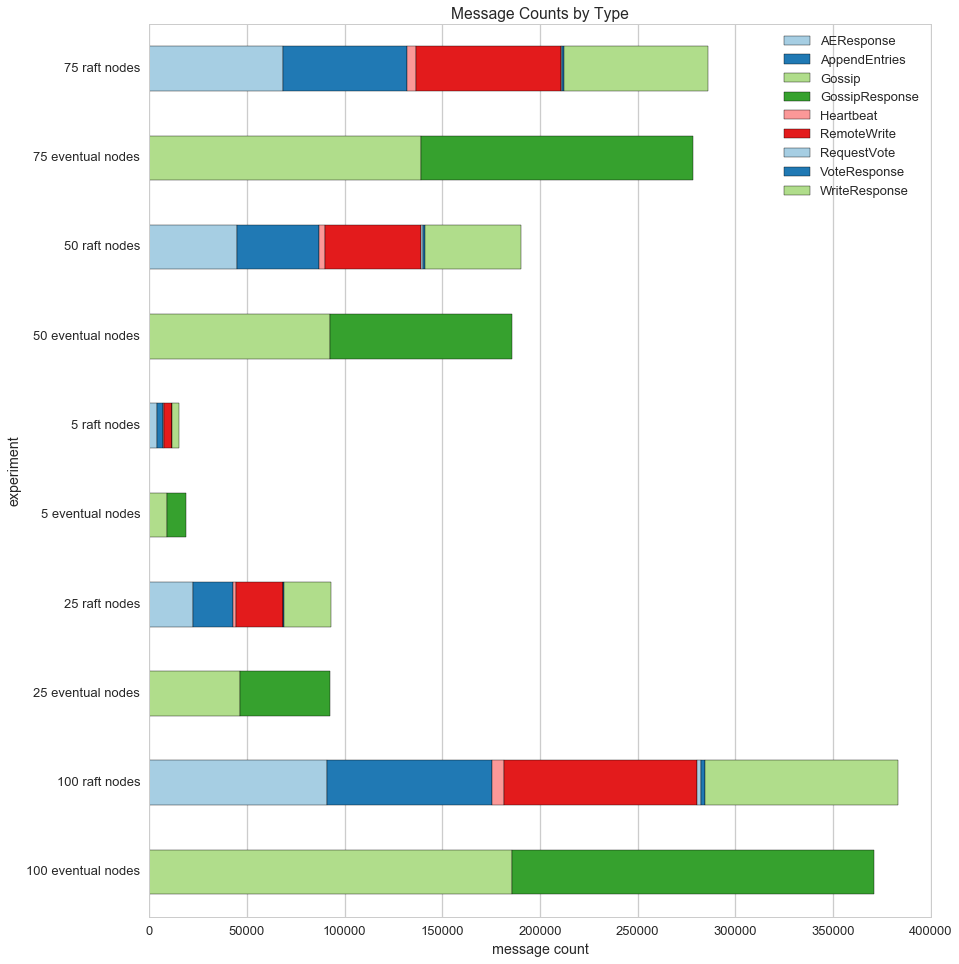

In [7]:
%%memit

def get_message_rows(df):
    for row in df[['message types', 'ename']].itertuples(): 
        item = row[1]
        item['experiment'] = row[2]
        yield item

# Create the data frame 
msgs = pd.DataFrame(sorted(get_message_rows(df), key=lambda item: item['experiment']))

# Create the figure 
fig = plt.figure(figsize=(14,16))
ax  = fig.add_subplot(111)
mpl.rcParams.update({'font.size': 22})

# Plot the bar chart 
g = msgs.plot(
    x='experiment', kind='barh', stacked=True, ax=ax, 
    title="Message Counts by Type", color=sns.color_palette()
)

# Modify the figure 
ax.set_xlabel("message count")
ax.yaxis.grid(False)

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'message_counts.png'))

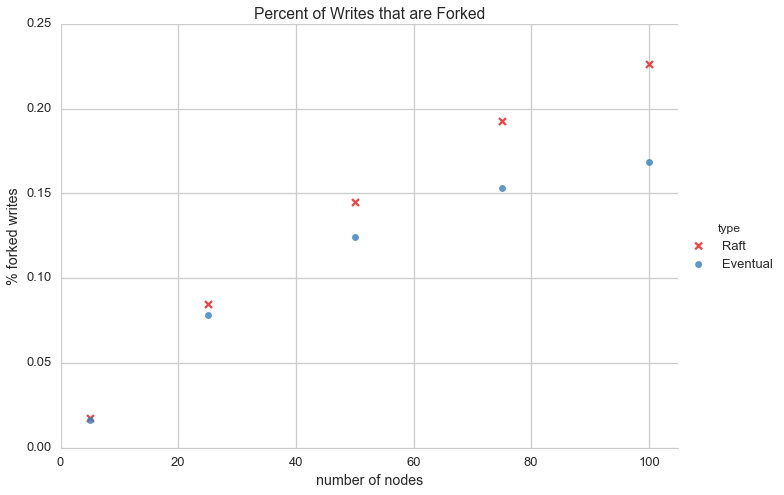

In [10]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
df['% forked writes'] = df['forked writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% forked writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Forked"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'forked_writes.png'))

In [ ]:
# Forked Writes (two keys: "inconsistent writes" and "forked writes")
g = sns.lmplot(
    x="users", y="inconsistent writes", hue='type',
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Inconsistent Writes for {:,} Accesses".format(df.writes.max())
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'inconsistent_writes.png'))

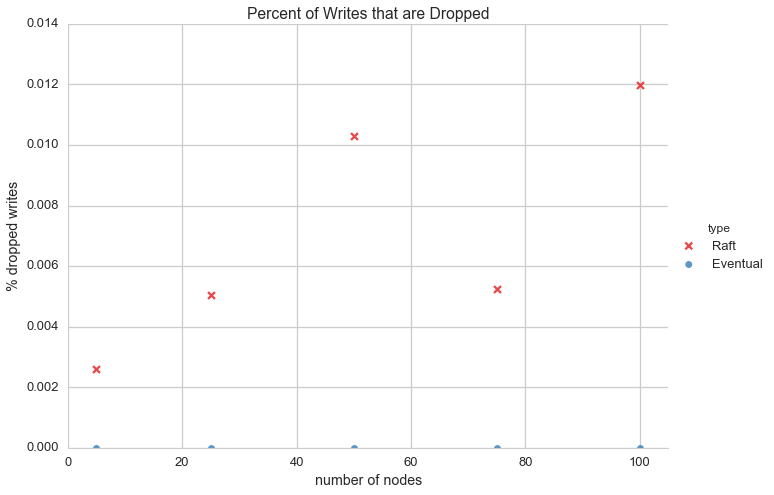

In [11]:
# Dropped Writes
df['% dropped writes'] = df['dropped writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% dropped writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Dropped"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'dropped_writes.png'))

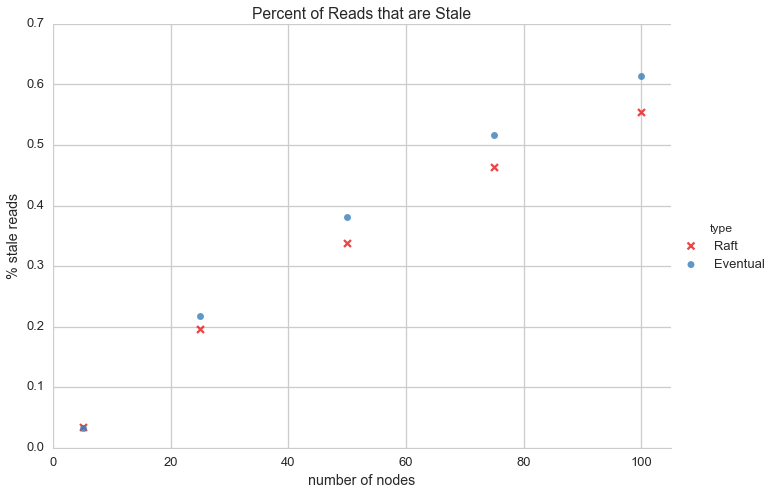

In [12]:
# Stale Reads
df['% stale reads'] = df['stale reads'] / df['reads']

g = sns.lmplot(
    x="users", y="% stale reads", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Reads that are Stale"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'stale_reads.png'))

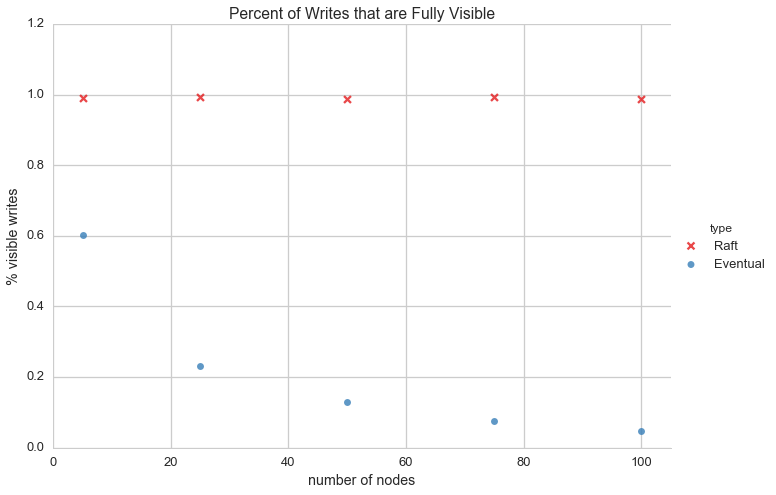

In [13]:
# Visible Writes
df['% visible writes'] = df['visible writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% visible writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Fully Visible"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visible_writes.png'))

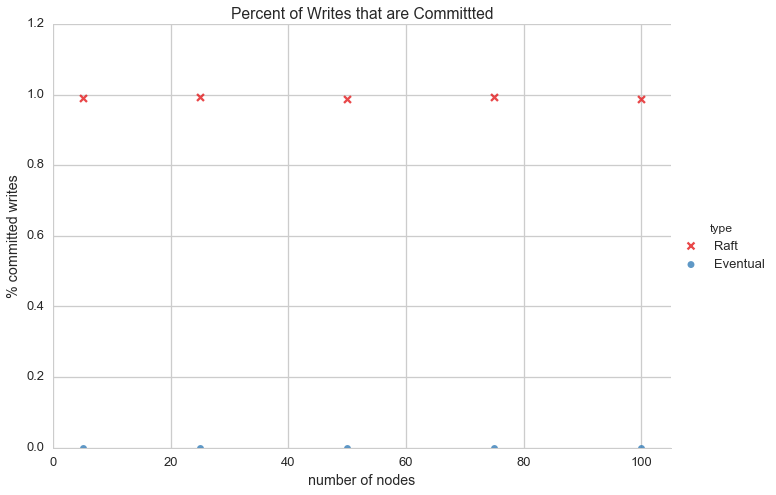

In [14]:
# Comitted Writes
df['% committed writes'] = df['committed writes'] / df['writes']

g = sns.lmplot(
    x="users", y="% committed writes", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Percent of Writes that are Committted"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'committed_writes.png'))

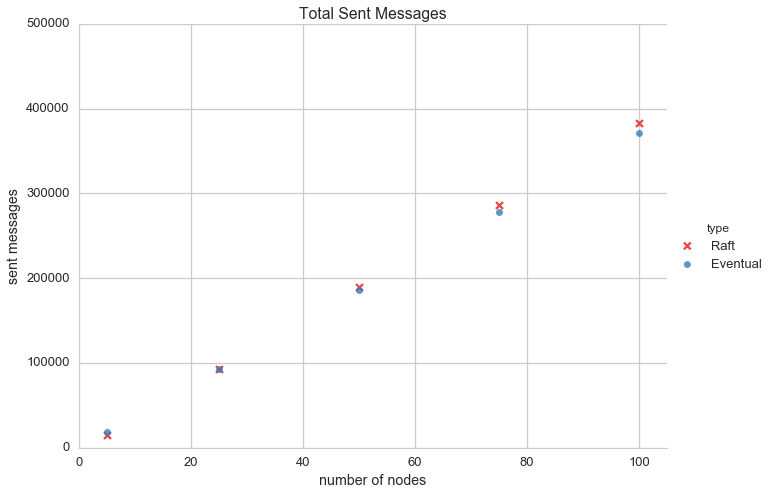

In [16]:
# Number of Messages 
g = sns.lmplot(
    x="users", y="sent messages", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4,  markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Total Sent Messages"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'messages_sent.png'))

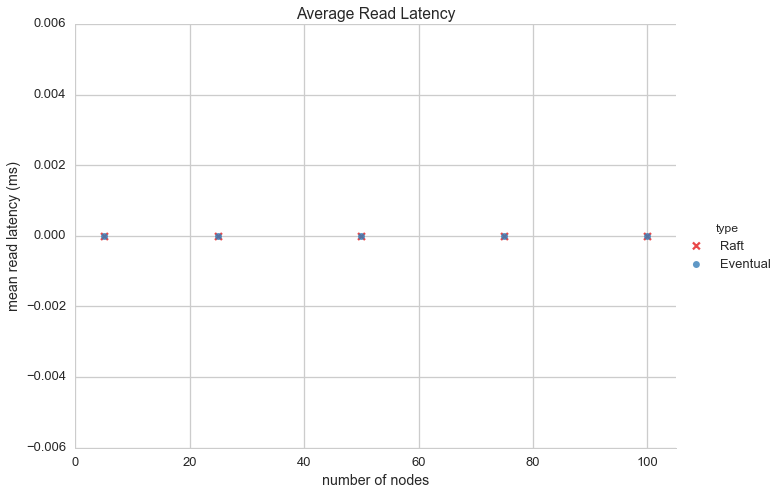

In [17]:
# Read latency (ms delay before read)
g = sns.lmplot(
    x="users", y="mean read latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Read Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'read_latency.png'))

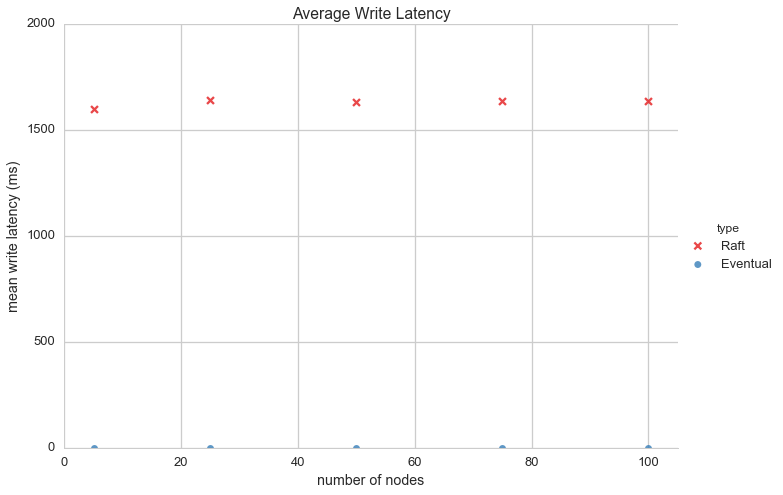

In [18]:
# Write Latency (ms delay before write)
g = sns.lmplot(
    x="users", y="mean write latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Write Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'write_latency.png'))

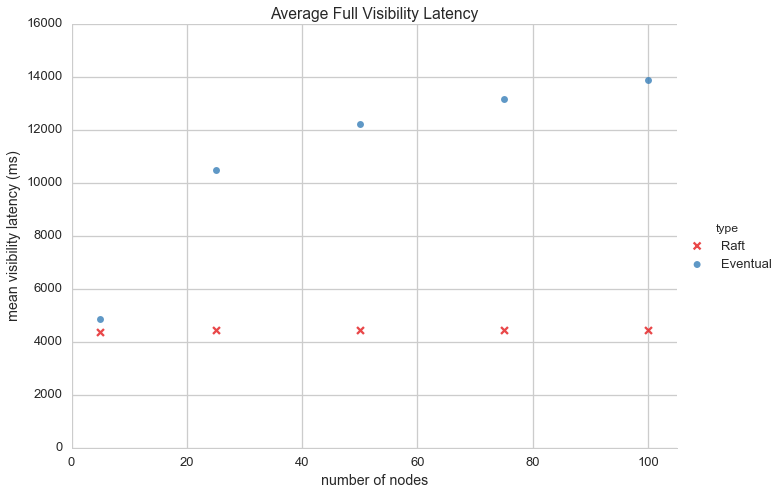

In [19]:
# Replication Latency (Visibility Latency)
g = sns.lmplot(
    x="users", y="mean visibility latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Full Visibility Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'visibility_latency.png'))

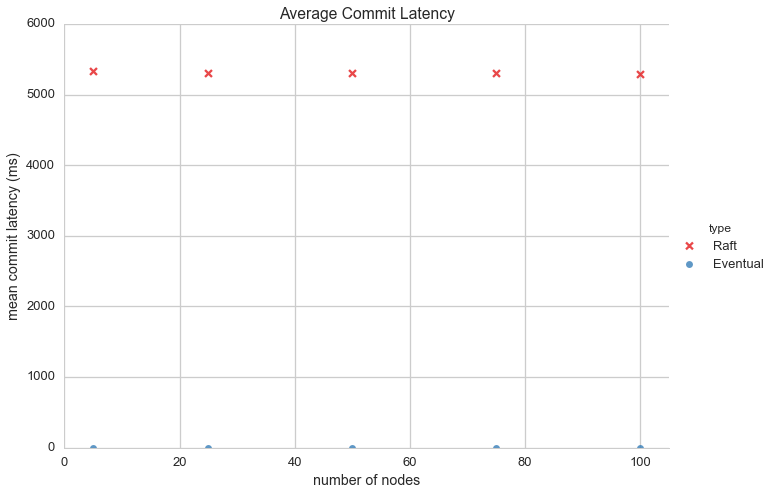

In [20]:
# Commit Latency
g = sns.lmplot(
    x="users", y="mean commit latency (ms)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Average Commit Latency"
g.ax.set_title(title_fmt)

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_ylim(0,)
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'commit_latency.png'))

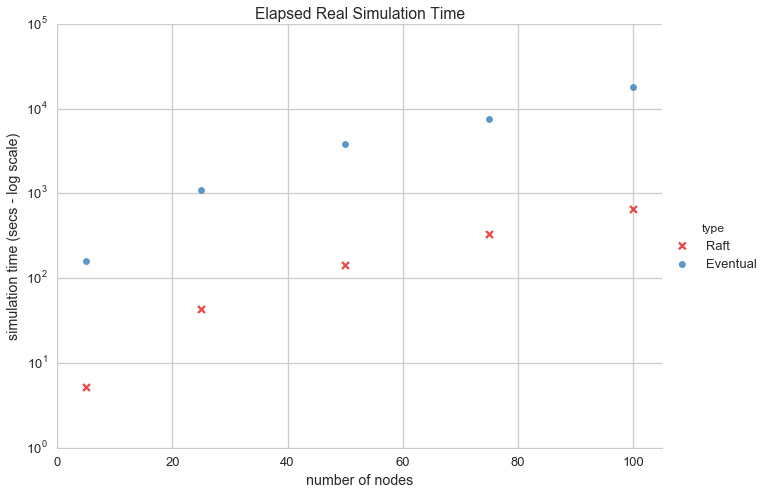

In [21]:
# Simulation Time
g = sns.lmplot(
    x="users", y="simulation time (secs)", hue='type', 
    data=df, fit_reg=False, size=7, aspect=1.4, markers=["x","o"],
    scatter_kws={'s': 48}
)

# Set the title and the labels 
title_fmt = "Elapsed Real Simulation Time"
g.ax.set_title(title_fmt)
g.set(yscale="log")
g.set(ylabel="simulation time (secs - log scale)")

# Modify the axis limits  
for ax in g.axes:
    ax[0].set_xlim(0,105)
    ax[0].set_xlabel("number of nodes")

# Save the figure to disk 
plt.savefig(os.path.join(FIGURES, 'simulation_time.png'))

In [ ]:
def find_results(etype='raft', users=None):
    for result in get_results_data():
        if result.settings['type'] == etype: 
            if (users and users == result.settings['users']) or users is None:
                name = "{}-{}nodes.png".format(etype, users)
                return result, name    
    return None, None 


# Find the desired results 
result, name = find_results('raft', 25)
if result is None: raise ValueError("Could not find results!")

# Extract the Graph Tool graph     
G = extract_graph(result, by_message_type=True)

# Draw the graph 
vlabel  = G.vp['id']
vsize   = G.vp['writes']
vsize   = gt.prop_to_size(vsize, ma=60, mi=20)

# Set the vertex color 
vcolor  = G.new_vertex_property('string') 
vcmap   = ColorMap('flatui', shuffle=False)
for vertex in G.vertices():
    vcolor[vertex] = vcmap(G.vp['consistency'][vertex])

# Set the edge color 
ecolor  = G.new_edge_property('string')
ecmap   = ColorMap('paired', shuffle=False)
for edge in G.edges():
    ecolor[edge] = ecmap(G.ep['label'][edge])

elabel  = G.ep['label']
esize   = G.ep['norm']
esize   = gt.prop_to_size(esize, mi=2, ma=5)

# Create the layout with the edge weights. 
# pos = gt.arf_layout(G, weight=G.ep['weight'])
pos = gt.sfdp_layout(G, eweight=G.ep['weight'], vweight=vsize)
# pos = gt.fruchterman_reingold_layout(G, weight=G.ep['weight'])

gt.graph_draw(
    G, pos=pos, output_size=(1200,1200), output=os.path.join(FIGURES, name),
    vertex_text=vlabel, vertex_size=vsize, vertex_font_weight=1, 
    vertex_pen_width=1.3, vertex_fill_color=vcolor,
    edge_pen_width=esize, edge_color=ecolor, edge_text=elabel
)